## 0. Import libraries 

In [1]:
# Standard Python libraries
import os
from pathlib import Path

# External packages
from garmin_fit_sdk import Decoder, Stream
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import contextily as cx

## 1. Define filepaths
1. `activity_directory` is the directory in which the FIT files are located
2. `activity_files` are the individual FIT files

In [2]:
# bounding box for Mpls
# poly = Polygon([(-93.29934112482803,44.94387885624785), (-93.17020332544818,44.94106314317192), (-93.17231728023113,45.00552790345714), (-93.30005261459098,45.00603023658404), (-93.29934112482803,44.94387885624785)])

# bounding box for Plymouth
poly = Polygon([(-93.52049250867496,44.96827130360321), (-93.40154030668695,44.96946555653578), (-93.40169534513595,45.04860429760565), (-93.51942755540024,45.0501045528026), (-93.52049250867496,44.96827130360321)])

activity_directory = r"HealthData\FitFiles\Activities"
intermediate_path = os.path.join(Path.home(), activity_directory)

activity_files = []
for file in os.listdir(intermediate_path):
    filepath = Path(file)
    if filepath.suffix.lower() == '.fit':
        activity_files.append(file)

## 2. Define functions

In [3]:
# function to convert semicircle coordinates into decimal degrees (WGS 84)

# Garmin saves its coordinates as semicircles, which reduces storage capacity,
# but it means that we have to convert it into a more useful geometry before we can use it.

def convert_semicircle_to_degrees(semicircle_value):
    return semicircle_value * (180 / 2**31)

In [4]:
def check_is_in_polygon(polygon_object, point):
    return point.within(polygon_object)

In [5]:
# open a FIT file given the parent directory (where it is stored) and the name of the specific file itself

def open_file(parent_directory, filename):
    home = Path.home()
    activity_filepath = os.path.join(home, parent_directory, filename)

    stream = Stream.from_file(activity_filepath)
    decoder = Decoder(stream)
    messages, errors = decoder.read()

    return messages

In [6]:
# extract the coordinates from each file and convert them into a LineString object

def convert_file_to_linestring(parent_directory, filename, polygon_object):
    messages = open_file(parent_directory, filename)

    coordinates = []        # save each coordinate as a tuple in this list

    # add each coordinate to the coordinates list
    i = 0       # keep track of data packets with missing coordinates

    # check first data packet to see if it's within the bounding polygon
    try:
        lat = convert_semicircle_to_degrees(messages['record_mesgs'][0]['position_lat'])
        long = convert_semicircle_to_degrees(messages['record_mesgs'][0]['position_long'])

        point = Point(long, lat)

        if check_is_in_polygon(polygon_object, point):
            for msg in messages['record_mesgs'][1:]:
                try:
                    lat = convert_semicircle_to_degrees(msg['position_lat'])
                    long = convert_semicircle_to_degrees(msg['position_long'])

                    point = Point(long, lat)

                    coordinates.append(Point(long, lat))
                except:     # some data packets don't have coordinates in them (when there are issues connecting to GPS)
                    i += 1

            line = LineString(coordinates)

            print(f'Number of data packets in {filename} with missing coordinates: {i}')

            return line
    except:
        pass

In [7]:
# build a GeoDataFrame where each row is a LineString object from one FIT file

def build_dataframe(activity_directory, activity_files, polygon_object):
    linestrings = []

    for file in activity_files:
        linestring = convert_file_to_linestring(activity_directory, file, polygon_object)
        if linestring is not None:
            linestrings.append(linestring)
        # linestrings.append(convert_file_to_linestring(activity_directory, file, polygon_object))
    
    indices = list(range(len(linestrings)))

    df_data = {'LineString_Num': indices, 'geometry': linestrings}

    gdf = gpd.GeoDataFrame(df_data, crs="EPSG:4326")        # use WGS 84

    return gdf

## 3. Build GeoDataFrame and plot it

#### ONLY RUN THE FOLLOWING CELL FOR AGGREGATING NEW DATA; OTHERWISE, OPEN THE RESPECTIVE FILE

In [8]:
my_gdf = build_dataframe(activity_directory, activity_files, poly)
my_gdf.to_file('ply_activities.geojson')

Number of data packets in 10035176526_ACTIVITY.fit with missing coordinates: 1
Number of data packets in 10039861273_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10045647404_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10077730584_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10147652091_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10156637044_ACTIVITY.fit with missing coordinates: 6
Number of data packets in 10161437718_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10166543146_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10175798395_ACTIVITY.fit with missing coordinates: 4
Number of data packets in 10180700456_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10184661873_ACTIVITY.fit with missing coordinates: 1
Number of data packets in 10195090971_ACTIVITY.fit with missing coordinates: 0
Number of data packets in 10200449166_ACTIVITY.fit w

In [ ]:
# my_gdf = gpd.read_file('ply_activities.geojson')

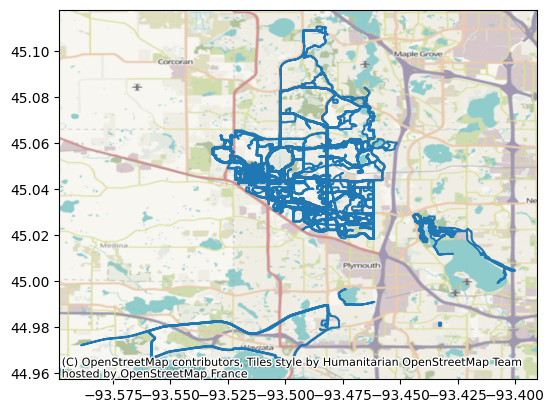

In [9]:
# plot the points

ax = my_gdf.plot(aspect=1, markersize=1)
cx.add_basemap(ax, crs=my_gdf.crs)
# plt.show()

In [68]:
'''
speed measured in m/s
distance measured in m

'record_mesgs' contains coordinates, etc.

{'timestamp': datetime.datetime(2019, 12, 29, 21, 26, 50, tzinfo=datetime.timezone.utc),
'position_lat': 537257002, 'position_long': -1115376201, 'distance': 0.0, 'altitude': 322.20000000000005,
'speed': 1.185, 'cycle_length16': 0.5, 88: 100, 'heart_rate': 86, 'cadence': 55, 'temperature': 26,
'fractional_cadence': 0.5, 'enhanced_speed': 1.185, 'enhanced_altitude': 322.20000000000005}
'''

"\nspeed measured in m/s\ndistance measured in m\n\n'record_mesgs' contains coordinates, etc.\n\n{'timestamp': datetime.datetime(2019, 12, 29, 21, 26, 50, tzinfo=datetime.timezone.utc),\n'position_lat': 537257002, 'position_long': -1115376201, 'distance': 0.0, 'altitude': 322.20000000000005,\n'speed': 1.185, 'cycle_length16': 0.5, 88: 100, 'heart_rate': 86, 'cadence': 55, 'temperature': 26,\n'fractional_cadence': 0.5, 'enhanced_speed': 1.185, 'enhanced_altitude': 322.20000000000005}\n"